In [1]:
import sys
REL_DIR  = "../../../../"
sys.path.append(REL_DIR)

# SiouxFalls - (Parametric) Price of Anarchy

## 1. Imports and data readin

First we load the paminco package and read the SiouxFalls data. 
The data was taken from [here](https://github.com/bstabler/TransportationNetworks) and converted to our format of choice: ``XML``.
The data for SiouxFalls comes with paminco and can be easily loaded: 

In [2]:
import paminco

sioux = paminco.load_sioux()

ModuleNotFoundError: No module named 'paminco'

By default the edge cost equal the link travel time: $F_e = l_e$. 
The link travel time is defined as
\begin{equation*}
l_e(x_e) = \text{fft}_e \cdot \left( 1 + B_e \cdot \left(\frac{x}{\text{cap}_e}\right) ^ {p_e} \right)
\end{equation*}

## 2. Fixed Price of Anarchy with Frank-Wolfe

We find minimum cost flows that coincide with user equilibrium and system optimum if we transform the edge cost by:
\begin{align}
\text{User equilibrium:} \quad F_e &= \int_0^{x_e} l_e(s) ds \\ 
\text{System optimum:} \quad F_e &= x_e \cdot l_e \\ 
\end{align}

In [21]:
import copy

# Calculate user equilibrium -> F_e = integral_0^(x_e) l_e(s)ds
sioux_ue = copy.deepcopy(sioux)
sioux_ue.cost.integrate(inplace=True)
fw_ue = paminco.NetworkFW(sioux_ue)
fw_ue.run(max_iter=500)

# Calculate system optimum -> F_e = x_e * l_e
sioux_so = copy.deepcopy(sioux) 
sioux_so.cost.times_x(inplace=True)
fw_so = paminco.NetworkFW(sioux_so)
fw_so.run(max_iter=500)

The [Price of Annarchy](https://en.wikipedia.org/wiki/Price_of_anarchy) (PoA) measures the inefficency of the network utilization due to selfish behaviour of the participants. 
It is calculated as the ratio of the total (or equivalently average) travel time for all particpants in the user equilbrium to that of the system optimum:

\begin{equation*}
\text{PoA} = \frac{C(\text{UE})}{C(\text{SO})},
\end{equation*}

where $C$ is the total system travel time (TSTT):
\begin{equation*}
\text{TTST}(\mathbf{x}) = x_e \cdot l_e,
\end{equation*}
i.e., the objective function of the system optimal minimum cost flow.

In [22]:
def TTST(x):
    return sioux_so.cost.F(x).sum()

The Price of Anarchy for SiouxFalls is about ``3.8 percent``:

In [24]:
poa = TTST(fw_ue.x) / TTST(fw_so.x)
poa

1.0388035864499006

## 3. Paramtric Price of Anarchy with MCA

The above example allowed to compute system inefficiency for a fixed demand $\mathbf{B}$. 

However, it is of interest how the POA varies by the demand multiplier $\lambda$.
We can achieve this with the ``MCA`` algorithm by calculating parametric user equilibira flows and parametric system optima:

In [27]:
sioux2 = copy.deepcopy(sioux)
sioux2.set_demand(("20", "3", 100000))

sioux_ue = copy.deepcopy(sioux2)
sioux_ue.cost.integrate(inplace=True)
mca_ue = paminco.MCA(sioux_ue)
mca_ue.run()

sioux_so = copy.deepcopy(sioux2) 
sioux_so.cost.times_x(inplace=True)
mca_so = paminco.MCA(sioux_so)
mca_so.run()

For any demand multiplier in $\lambda \in [0, 1]$, we can now compute a price of anarchy:

In [54]:
import numpy as np

lambdas = np.linspace(1e-5, 1, 100)

cost_user_equilibira = np.array([TTST(mca_ue.flow_at(l)) for l in lambdas])
cost_system_optima = np.array([TTST(mca_so.flow_at(l)) for l in lambdas])
paramtric_poa = cost_user_equilibira / cost_system_optima

Text(0.5, 1.0, 'Parametric Price of Anarchy')

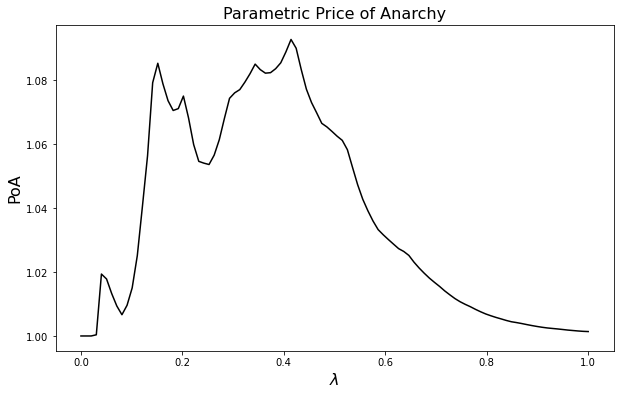

In [55]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(lambdas, paramtric_poa, color="black")
ax.set_xlabel("$\lambda$", fontsize=16)
ax.set_ylabel("PoA", fontsize=16)
ax.set_title("Parametric Price of Anarchy", fontsize=16)